In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [6]:
import os

In [65]:
data = pd.read_csv('preprocessed_data.csv',index_col=None,header=0)
data = data[['id','depth','parent_id','score','lemmatized','lemm_sub','sentiment','subjectivity','sentiment_sub','subjectivity_sub','labels']]

In [66]:
data.head()
data.dropna(inplace=True)

In [67]:
data.loc[data['labels'] == 'supporting', 'labels'] = 0
data.loc[data['labels'] == 'denying', 'labels'] = 1
data.loc[data['labels'] == 'questioning', 'labels'] = 2
data.loc[data['labels'] == 'commenting', 'labels'] = 3

In [68]:
data.head()

,id,depth,parent_id,score,lemmatized,lemm_sub,sentiment,subjectivity,sentiment_sub,subjectivity_sub,labels
0,d4xury6,0,t3_4r2tl4,31,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,0.333333,0.416667,0.114394,0.533718,0
1,d4yi9y9,0,t3_4r2tl4,7,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,0.104167,0.308333,0.114394,0.533718,0
2,d4yhm4h,0,t3_4r2tl4,7,people nice friendly super non judgmental espe...,updated september scroll downhi lengthy post c...,0.189815,0.540741,0.114394,0.533718,3
3,d4y5kmd,0,t3_4r2tl4,3,thanks post tried yaz oral contraceptive prior...,updated september scroll downhi lengthy post c...,0.133333,0.133333,0.114394,0.533718,0
4,d4y8tvk,0,t3_4r2tl4,3,minor need show parent consent,updated september scroll downhi lengthy post c...,-0.050000,0.200000,0.114394,0.533718,2


In [69]:
labels = to_categorical(data['labels'], num_classes=4)
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [70]:
n_most_common_words = 8000
max_len = 2000
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['lemmatized'].values)
sequences = tokenizer.texts_to_sequences(data['lemmatized'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 4840 unique tokens.


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [84]:
epochs = 2
emb_dim = 128
batch_size = 256
labels[:2]

['supporting', 'denying']

In [85]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((865, 2000), (865, 4), (289, 2000), (289, 4))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2000, 128)         1024000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 2000, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None
Train on 692 samples, validate on 173 samples
Epoch 1/2
692/692 [==============================] - 173s 250ms/step - loss: 1.3853 - acc: 0.2428 - val_loss: 1.3730 - val_acc: 0.5376
Epoch 2/2
692/692 [============

In [86]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

289/289 [==============================] - 4s 13ms/step
Test set
  Loss: 1.365
  Accuracy: 0.491


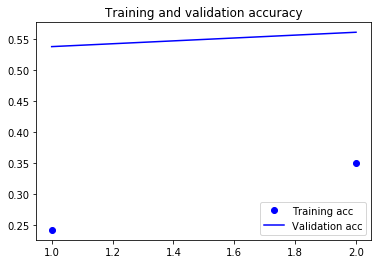

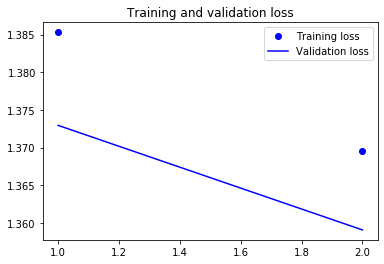

In [87]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [88]:
txt = ["thank you"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['supporting', 'denying', 'questioning', 'commenting']
print(pred, labels[np.argmax(pred)])

[[0.25504154 0.23584324 0.23785833 0.27125692]] commenting
